In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.datasets import fashion_mnist

from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose,Reshape
import scipy.signal as signal
from imgaug import augmenters

Using TensorFlow backend.


# MNIST
## Ruido Gaussiano

In [2]:
%matplotlib inline

batch_size = 256
original_dim = 784
latent_dim = 8
epochs = 50
epsilon_std = 1.0
noise_factor = 0.4
#Inicialización de los datos.
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), 28,28,1))
x_test = x_test.reshape((len(x_test), 28,28,1))

In [3]:
noise_train = x_train + noise_factor * np.random.randn(*x_train.shape)
noise_test = x_test + noise_factor * np.random.randn(*x_test.shape)
# Clip the images to be between 0 and 1
noise_train = np.clip(noise_train, 0., 1.)
noise_test = np.clip(noise_test, 0., 1.)

#encoder part
x_noise = Input(shape=(28,28,1))
conv_1 = Conv2D(64,(3, 3), padding='valid',activation='relu')(x_noise)
conv_2 = Conv2D(64,(3, 3), padding='valid',activation='relu')(conv_1)
pool_1 = MaxPooling2D((2, 2))(conv_2)
conv_3 = Conv2D(32,(3, 3), padding='valid',activation='relu')(pool_1)
pool_2 = MaxPooling2D((2, 2))(conv_3)

h=Flatten()(pool_2)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

#reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])


#decoder part
# we instantiate these layers separately so as to reuse them later
z=Reshape([1,1,latent_dim])(z)
conv_0T = Conv2DTranspose(128,(1, 1), padding='valid',activation='relu')(z)#1*1
conv_1T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_0T)#3*3
conv_2T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_1T)#5*5
conv_3T = Conv2DTranspose(48,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_2T)#10*10
conv_4T = Conv2DTranspose(48,(3, 3), padding='valid',activation='relu')(conv_3T)#12*12
conv_5T = Conv2DTranspose(32,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_4T)#24*24
conv_6T = Conv2DTranspose(16,(3, 3), padding='valid',activation='relu')(conv_5T)#26*26
x_out = Conv2DTranspose(1,(3, 3), padding='valid',activation='sigmoid')(conv_6T)#28*28

# instantiate VAE model
vae = Model(x_noise, x_out)

vae.compile(optimizer='adam', loss='binary_crossentropy')


hist = vae.fit(noise_train,x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(noise_test, x_test))

digit_size = 28
n_images=6
figure = np.zeros((digit_size * 3, digit_size * n_images))
num_test=10000
showidx=np.random.randint(0,num_test,n_images)

W0703 02:35:57.046364 140537740740352 deprecation_wrapper.py:119] From /root/anaconda3/envs/Tesis2/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0703 02:35:57.109851 140537740740352 deprecation_wrapper.py:119] From /root/anaconda3/envs/Tesis2/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0703 02:35:57.139774 140537740740352 deprecation_wrapper.py:119] From /root/anaconda3/envs/Tesis2/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0703 02:35:57.188696 140537740740352 deprecation_wrapper.py:119] From /root/anaconda3/envs/Tesis2/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 348s 6ms/step - loss: 0.2925 - val_loss: 0.1996
Epoch 2/50
60000/60000 [==============================] - 356s 6ms/step - loss: 0.1696 - val_loss: 0.1542
Epoch 3/50
60000/60000 [==============================] - 326s 5ms/step - loss: 0.1494 - val_loss: 0.1438
Epoch 4/50
60000/60000 [==============================] - 314s 5ms/step - loss: 0.1422 - val_loss: 0.1386
Epoch 5/50
60000/60000 [==============================] - 335s 6ms/step - loss: 0.1375 - val_loss: 0.1345
Epoch 6/50
60000/60000 [==============================] - 337s 6ms/step - loss: 0.1344 - val_loss: 0.1327
Epoch 7/50
60000/60000 [==============================] - 366s 6ms/step - loss: 0.1320 - val_loss: 0.1313
Epoch 8/50
60000/60000 [==============================] - 351s 6ms/step - loss: 0.1300 - val_loss: 0.1288
Epoch 9/50
60000/60000 [==============================] - 349s 6ms/step - loss: 0.1285 - val_loss: 0.1

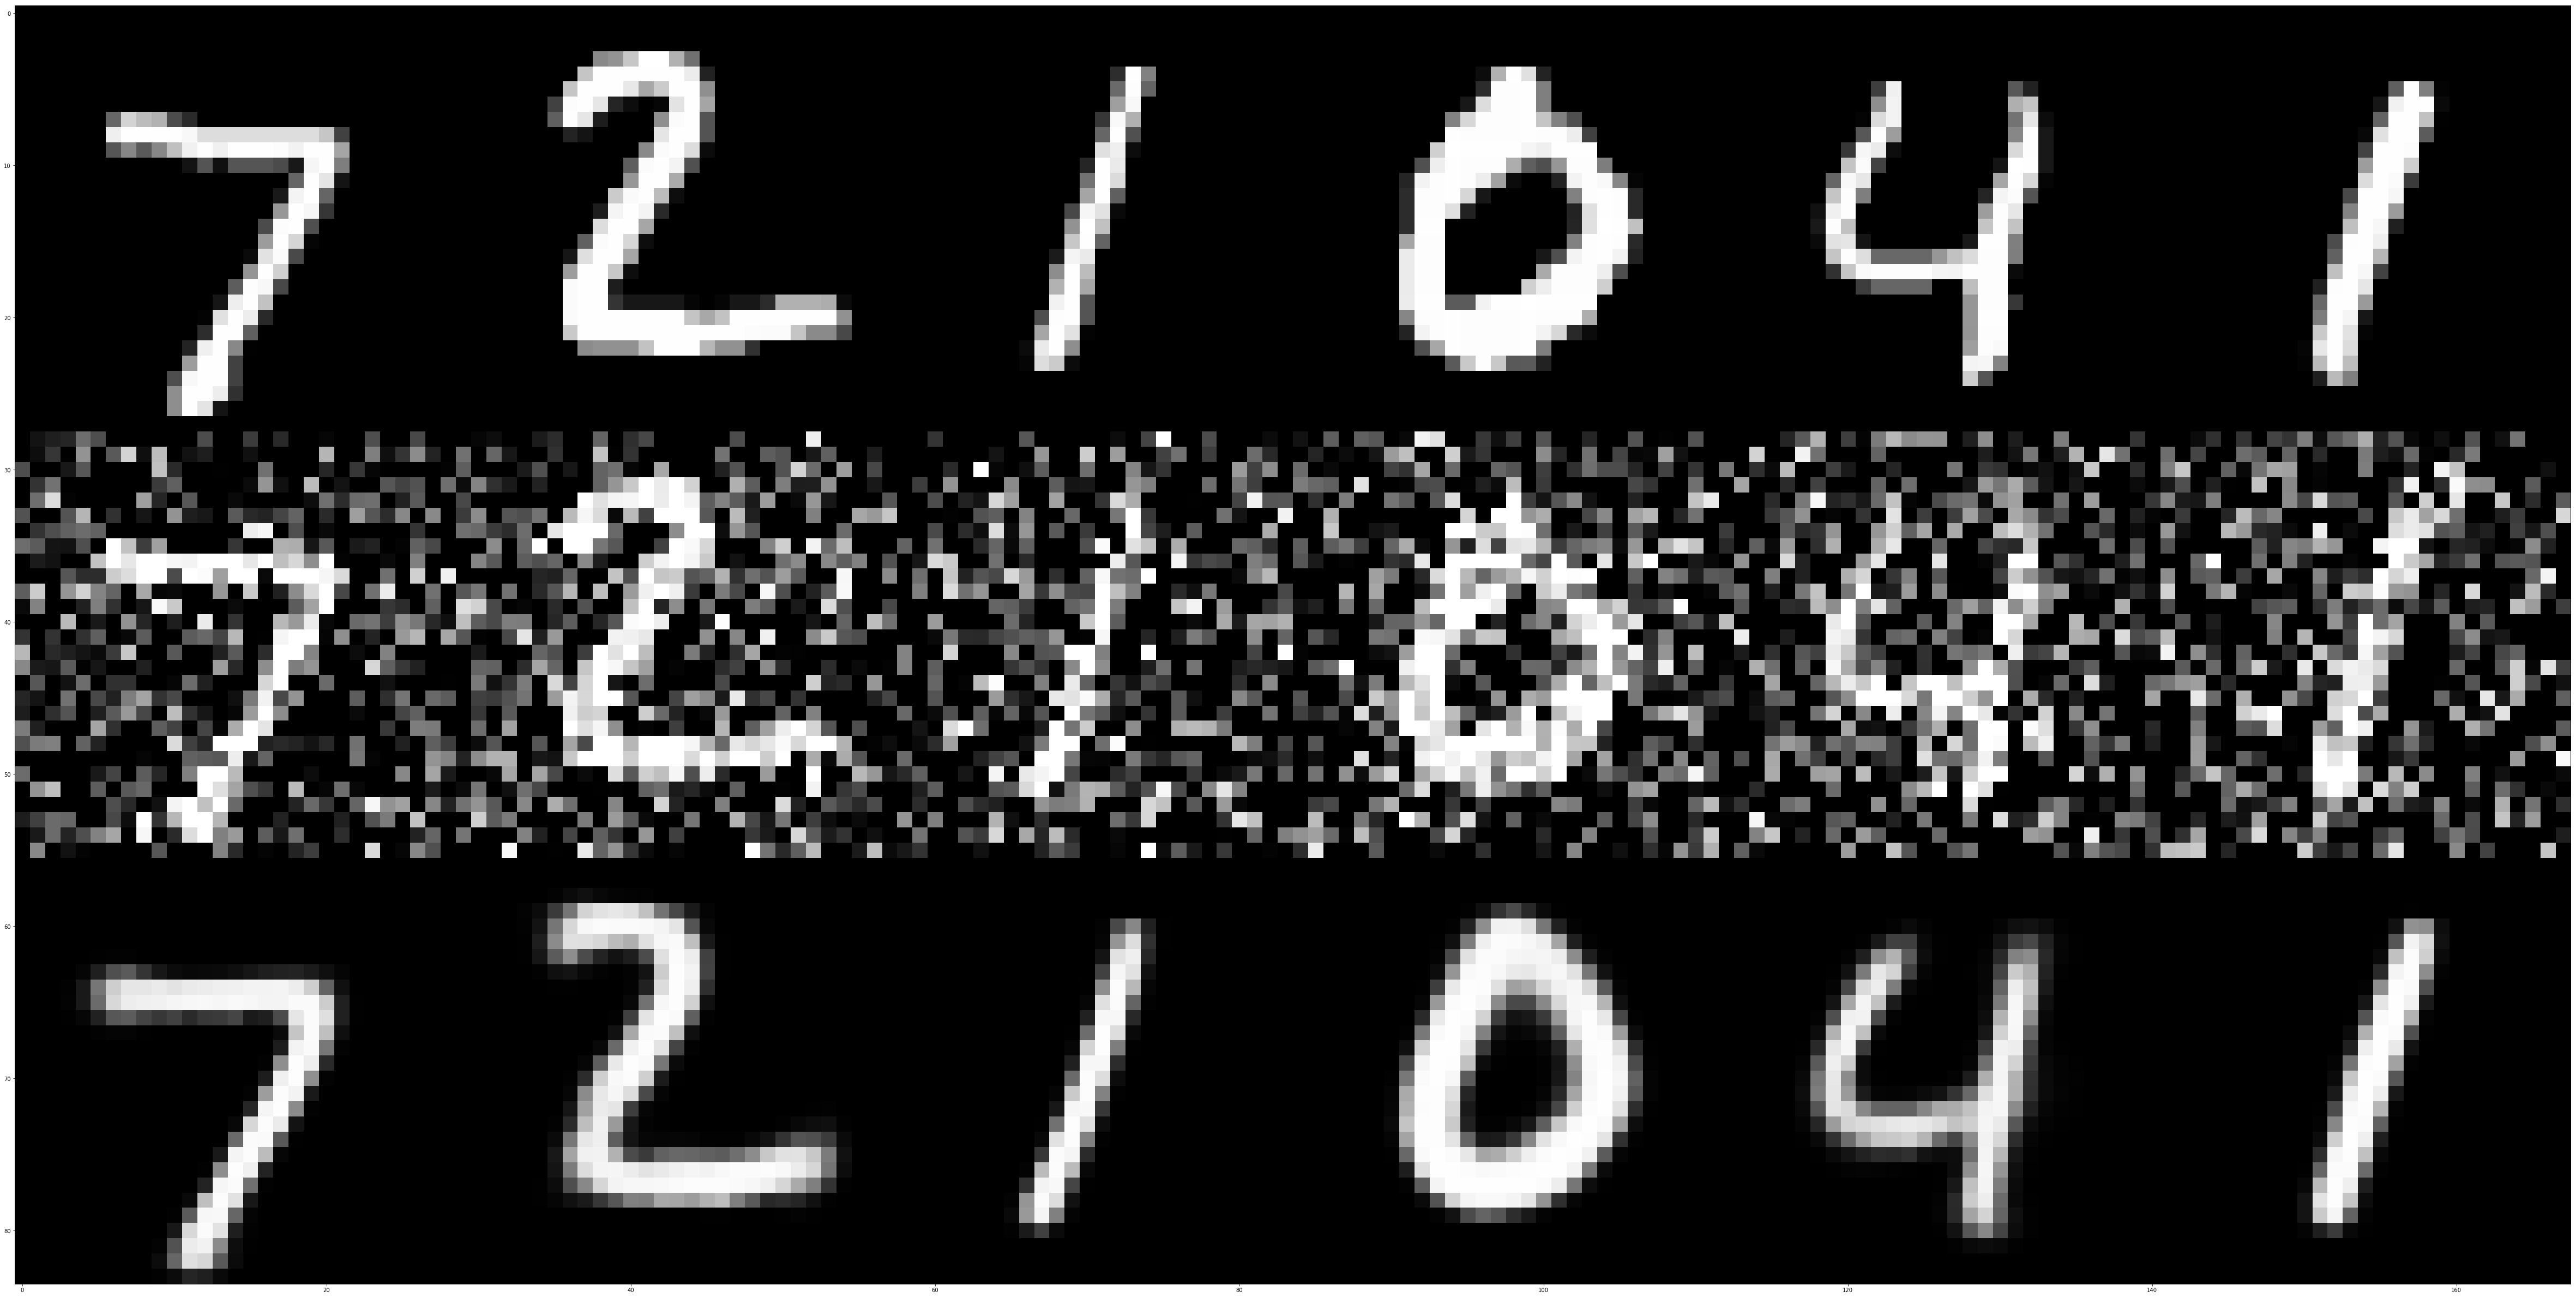

In [4]:
x_out=vae.predict(noise_test)
for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_test[i], [28, 28])
    figure[28: 28 * 2,i *28: (i + 1) * 28] = np.reshape(noise_test[i], [28, 28])
    figure[28 * 2: 28 * 3,i *28: (i + 1) * 28] = np.reshape(x_out[i], [28, 28])
plt.figure(figsize=(28 * 3, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.savefig('VAE-Orig-Mnist-Gauss.png')
plt.show()

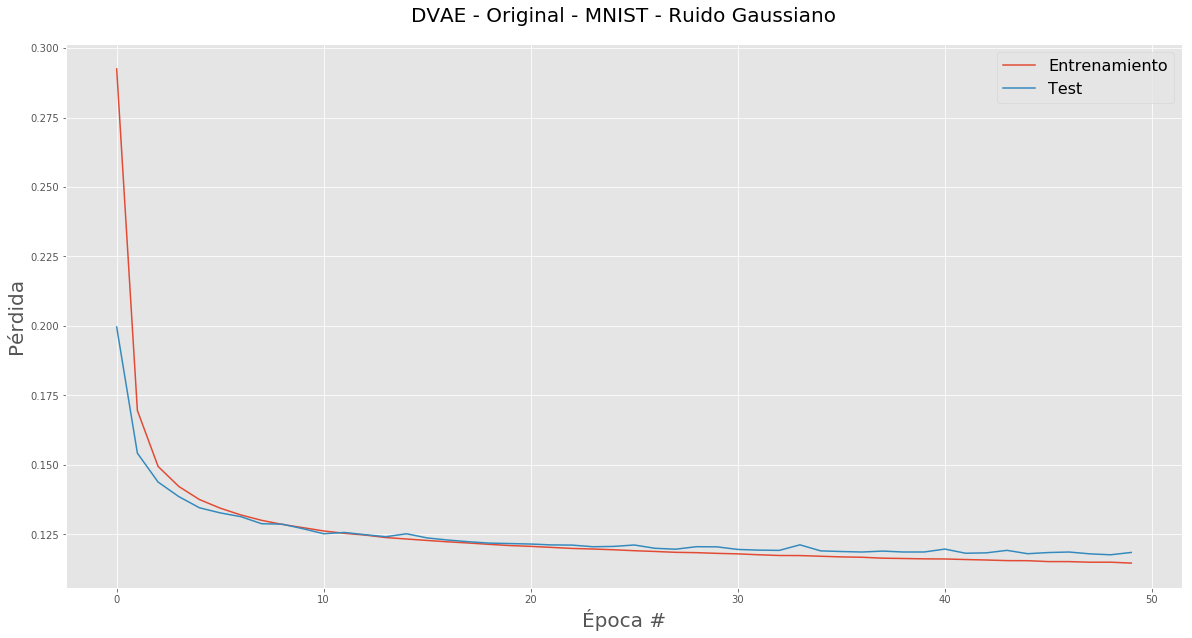

In [5]:
N=epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10))
plt.plot(np.arange(0, N), hist.history["loss"], label="Entrenamiento")
plt.plot(np.arange(0, N), hist.history["val_loss"], label="Test")
plt.title("DVAE - Original - MNIST - Ruido Gaussiano",fontsize=20,y=1.03)
plt.xlabel("Época #",fontsize=20)
plt.ylabel("Pérdida",fontsize=20)
plt.legend(loc="upper right",prop={'size': 16})
plt.savefig('VAE Orig-Mnist-Gauss-Plot.png')

## Ruido Sal y pimienta

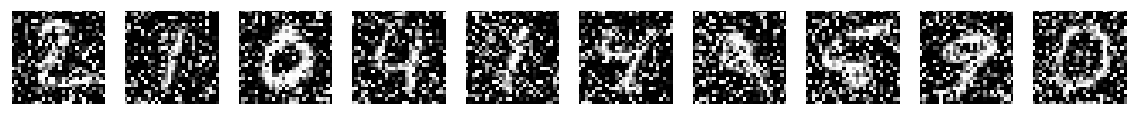

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 358s 6ms/step - loss: 0.3209 - val_loss: 0.2085
Epoch 2/50
60000/60000 [==============================] - 338s 6ms/step - loss: 0.1759 - val_loss: 0.1562
Epoch 3/50
60000/60000 [==============================] - 327s 5ms/step - loss: 0.1518 - val_loss: 0.1458
Epoch 4/50
60000/60000 [==============================] - 313s 5ms/step - loss: 0.1445 - val_loss: 0.1401
Epoch 5/50
60000/60000 [==============================] - 311s 5ms/step - loss: 0.1400 - val_loss: 0.1377
Epoch 6/50
60000/60000 [==============================] - 315s 5ms/step - loss: 0.1367 - val_loss: 0.1354
Epoch 7/50
60000/60000 [==============================] - 326s 5ms/step - loss: 0.1342 - val_loss: 0.1321
Epoch 8/50
60000/60000 [==============================] - 313s 5ms/step - loss: 0.1322 - val_loss: 0.1309
Epoch 9/50
60000/60000 [==============================] - 312s 5ms/step - loss: 0.1305 - val_loss: 0.1

In [6]:

noise = augmenters.SaltAndPepper(0.4)
seq_object = augmenters.Sequential([noise])

noise_train = seq_object.augment_images(x_train * 255) / 255
noise_test = seq_object.augment_images(x_test * 255) / 255

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(noise_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


#encoder part
x_noise = Input(shape=(28,28,1))
conv_1 = Conv2D(64,(3, 3), padding='valid',activation='relu')(x_noise)
conv_2 = Conv2D(64,(3, 3), padding='valid',activation='relu')(conv_1)
pool_1 = MaxPooling2D((2, 2))(conv_2)
conv_3 = Conv2D(32,(3, 3), padding='valid',activation='relu')(pool_1)
pool_2 = MaxPooling2D((2, 2))(conv_3)

h=Flatten()(pool_2)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

#reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])


#decoder part
# we instantiate these layers separately so as to reuse them later
z=Reshape([1,1,latent_dim])(z)
conv_0T = Conv2DTranspose(128,(1, 1), padding='valid',activation='relu')(z)#1*1
conv_1T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_0T)#3*3
conv_2T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_1T)#5*5
conv_3T = Conv2DTranspose(48,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_2T)#10*10
conv_4T = Conv2DTranspose(48,(3, 3), padding='valid',activation='relu')(conv_3T)#12*12
conv_5T = Conv2DTranspose(32,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_4T)#24*24
conv_6T = Conv2DTranspose(16,(3, 3), padding='valid',activation='relu')(conv_5T)#26*26
x_out = Conv2DTranspose(1,(3, 3), padding='valid',activation='sigmoid')(conv_6T)#28*28

# instantiate VAE model
vae = Model(x_noise, x_out)

# Compute VAE loss
def VAE_loss(x_origin,x_out):
    x_origin=K.flatten(x_origin)
    x_out=K.flatten(x_out)
    xent_loss = original_dim * metrics.binary_crossentropy(x_origin, x_out)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

vae.compile(optimizer='adam', loss='binary_crossentropy')


hist = vae.fit(noise_train,x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(noise_test, x_test))

digit_size = 28
n_images=6
figure = np.zeros((digit_size * 3, digit_size * n_images))
num_test=10000
showidx=np.random.randint(0,num_test,n_images)


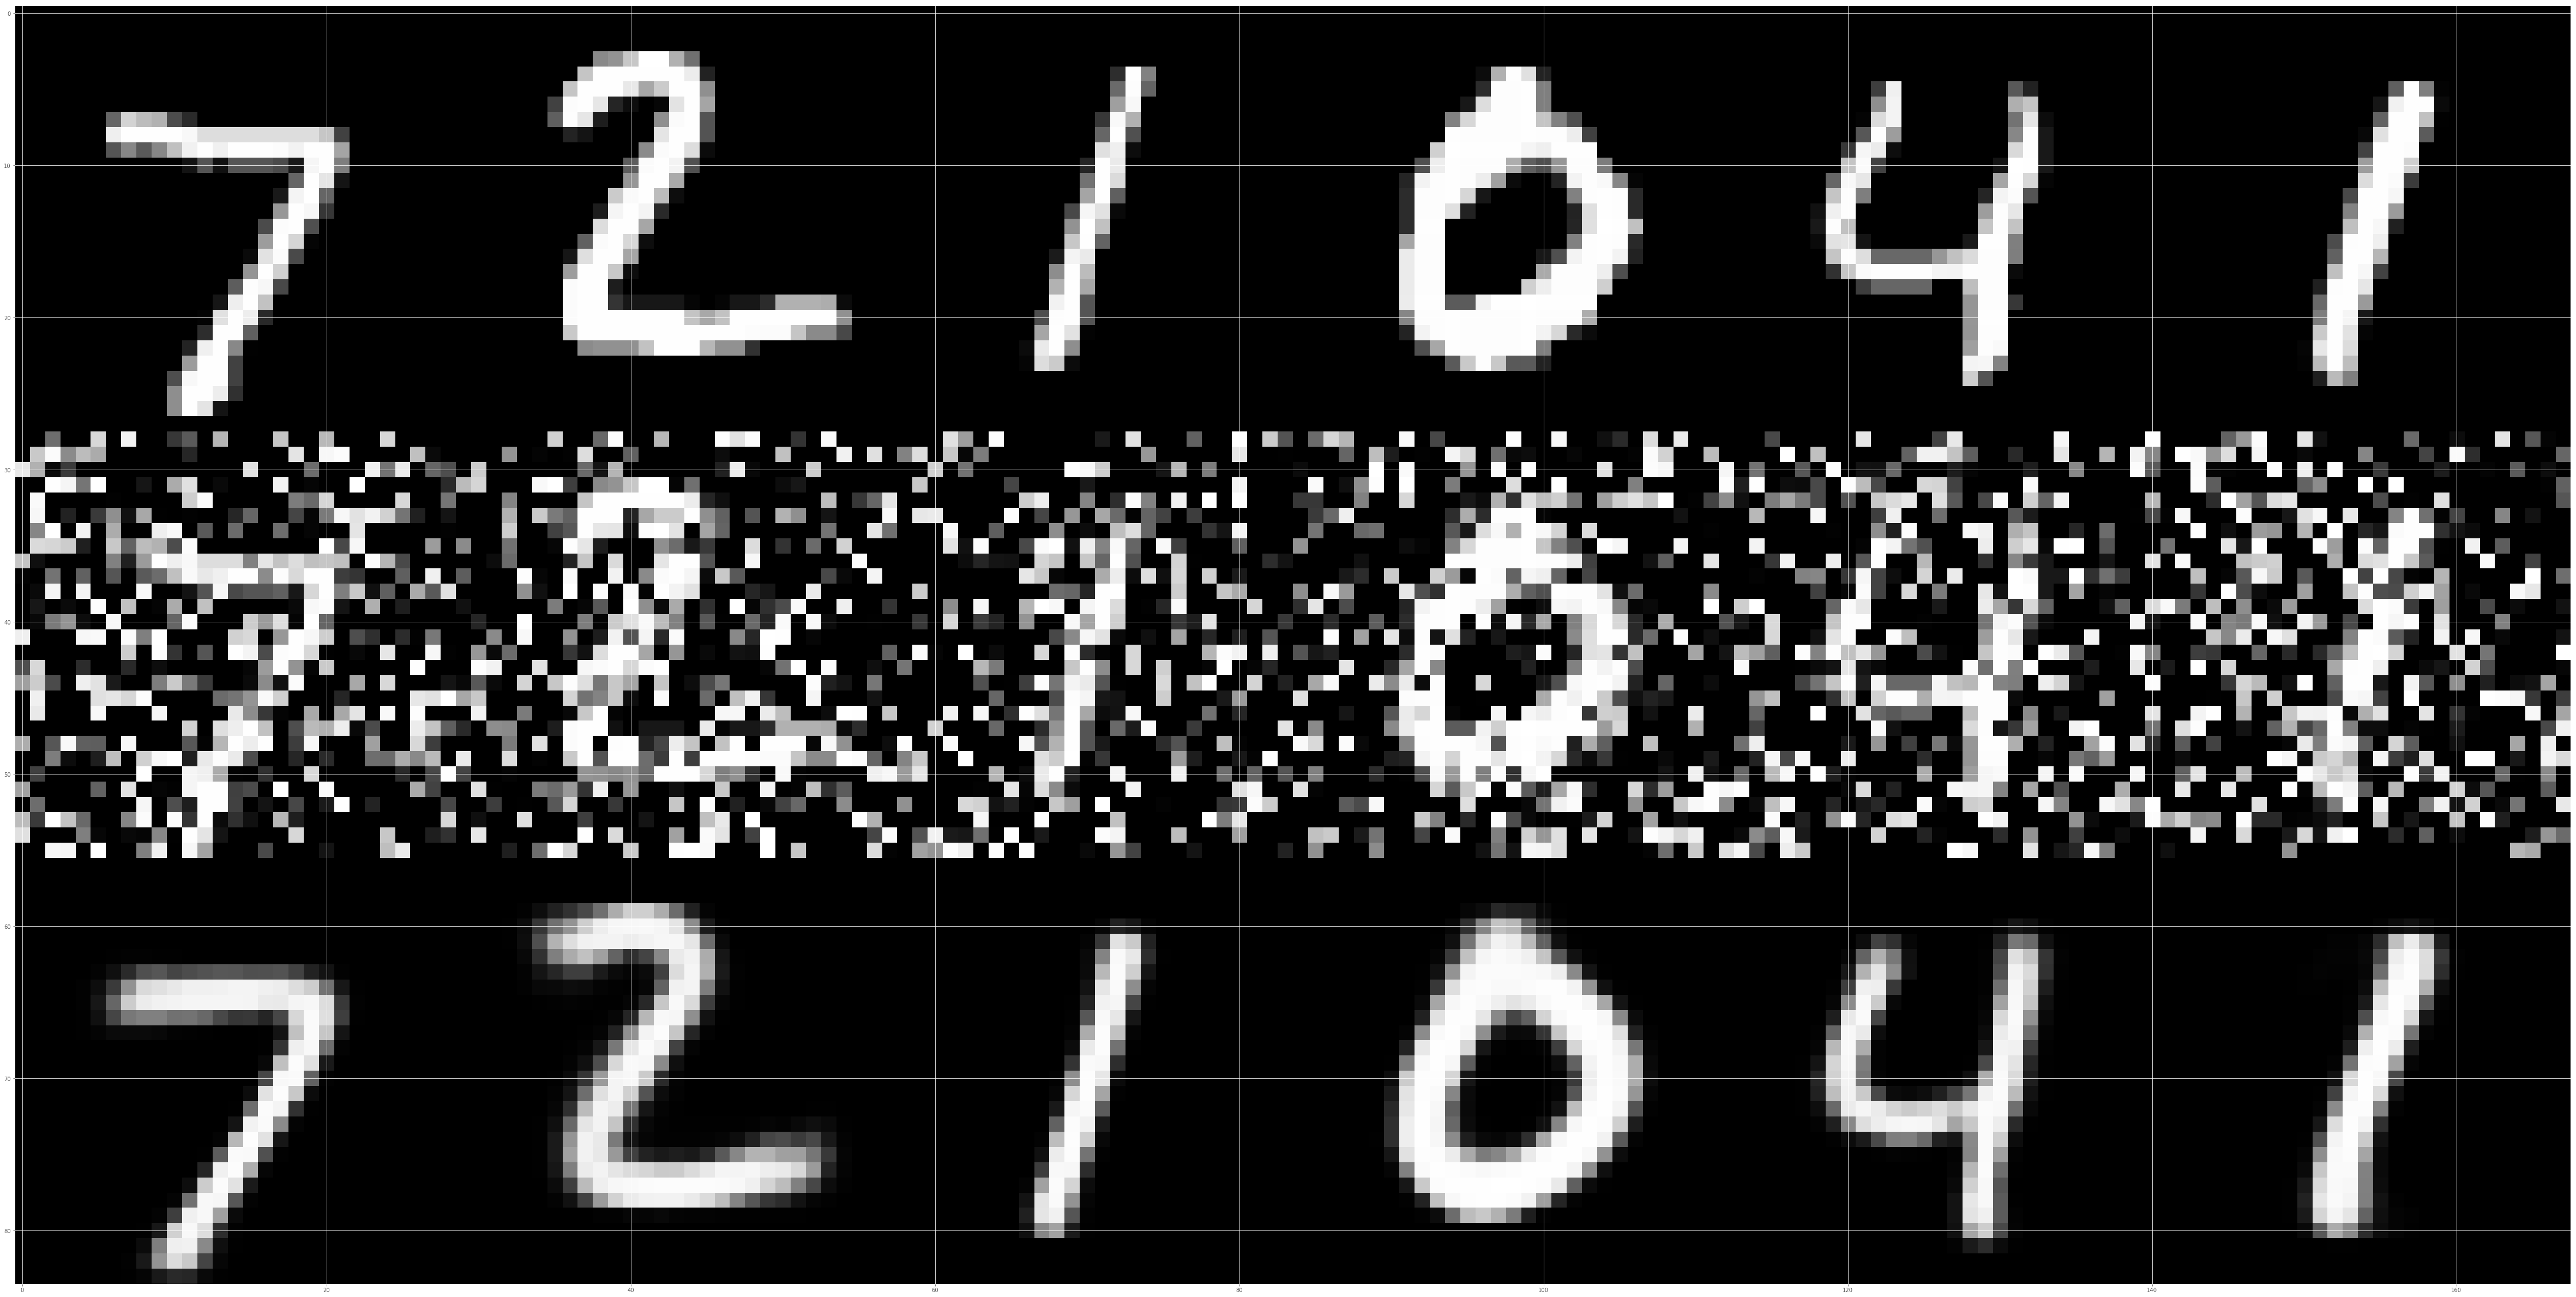

In [7]:
x_out=vae.predict(noise_test)
for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_test[i], [28, 28])
    figure[28: 28 * 2,i *28: (i + 1) * 28] = np.reshape(noise_test[i], [28, 28])
    figure[28 * 2: 28 * 3,i *28: (i + 1) * 28] = np.reshape(x_out[i], [28, 28])
plt.figure(figsize=(28 * 3, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.savefig('VAE-Orig-Mnist-SyP.png')
plt.show()

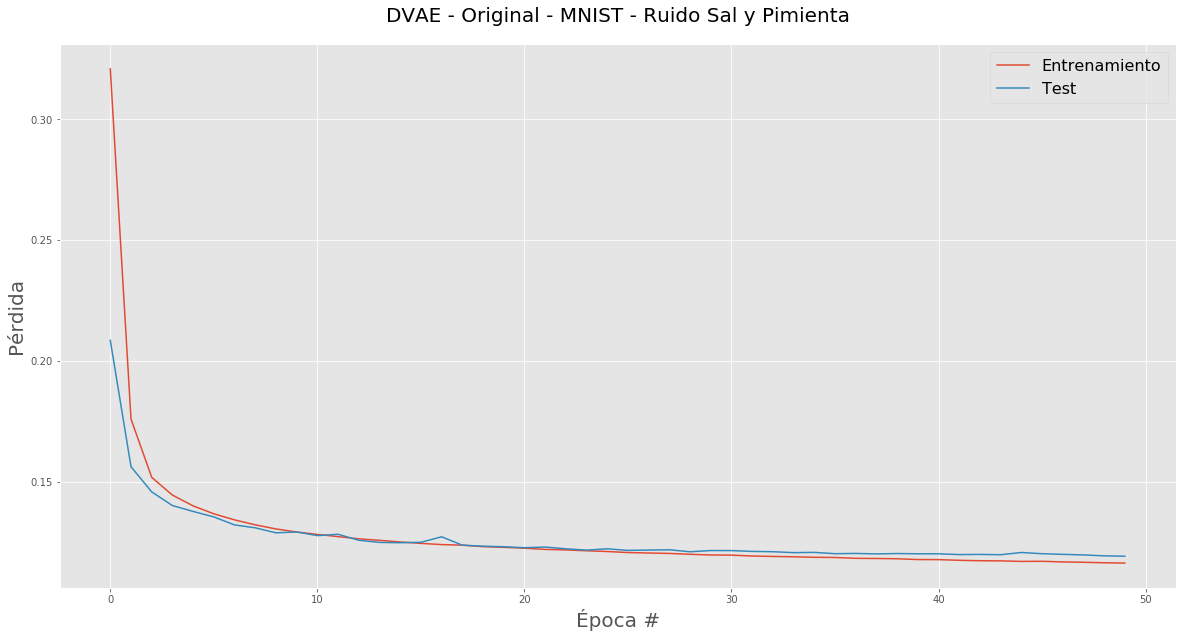

In [8]:
N=epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10))
plt.plot(np.arange(0, N), hist.history["loss"], label="Entrenamiento")
plt.plot(np.arange(0, N), hist.history["val_loss"], label="Test")
plt.title("DVAE - Original - MNIST - Ruido Sal y Pimienta",fontsize=20,y=1.03)
plt.xlabel("Época #",fontsize=20)
plt.ylabel("Pérdida",fontsize=20)
plt.legend(loc="upper right",prop={'size': 16})
plt.savefig('VAE Orig-Mnist-Gauss-SyP.png')

## Ruido Sal

In [ ]:
noise = augmenters.Salt(0.4)
seq_object = augmenters.Sequential([noise])

noise_train = seq_object.augment_images(x_train * 255) / 255
noise_test = seq_object.augment_images(x_test * 255) / 255

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(noise_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


#encoder part
x_noise = Input(shape=(28,28,1))
conv_1 = Conv2D(64,(3, 3), padding='valid',activation='relu')(x_noise)
conv_2 = Conv2D(64,(3, 3), padding='valid',activation='relu')(conv_1)
pool_1 = MaxPooling2D((2, 2))(conv_2)
conv_3 = Conv2D(32,(3, 3), padding='valid',activation='relu')(pool_1)
pool_2 = MaxPooling2D((2, 2))(conv_3)

h=Flatten()(pool_2)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

#reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])


#decoder part
# we instantiate these layers separately so as to reuse them later
z=Reshape([1,1,latent_dim])(z)
conv_0T = Conv2DTranspose(128,(1, 1), padding='valid',activation='relu')(z)#1*1
conv_1T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_0T)#3*3
conv_2T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_1T)#5*5
conv_3T = Conv2DTranspose(48,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_2T)#10*10
conv_4T = Conv2DTranspose(48,(3, 3), padding='valid',activation='relu')(conv_3T)#12*12
conv_5T = Conv2DTranspose(32,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_4T)#24*24
conv_6T = Conv2DTranspose(16,(3, 3), padding='valid',activation='relu')(conv_5T)#26*26
x_out = Conv2DTranspose(1,(3, 3), padding='valid',activation='sigmoid')(conv_6T)#28*28

# instantiate VAE model
vae = Model(x_noise, x_out)

# Compute VAE loss
def VAE_loss(x_origin,x_out):
    x_origin=K.flatten(x_origin)
    x_out=K.flatten(x_out)
    xent_loss = original_dim * metrics.binary_crossentropy(x_origin, x_out)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

vae.compile(optimizer='adam', loss='binary_crossentropy')


hist = vae.fit(noise_train,x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(noise_test, x_test))

digit_size = 28
n_images=6
figure = np.zeros((digit_size * 3, digit_size * n_images))
num_test=10000
showidx=np.random.randint(0,num_test,n_images)



In [ ]:
x_out=vae.predict(noise_test)
for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_test[i], [28, 28])
    figure[28: 28 * 2,i *28: (i + 1) * 28] = np.reshape(noise_test[i], [28, 28])
    figure[28 * 2: 28 * 3,i *28: (i + 1) * 28] = np.reshape(x_out[i], [28, 28])
plt.figure(figsize=(28 * 3, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.savefig('VAE-Orig-Mnist-Sal.png')
plt.show()

In [ ]:
N=epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10))
plt.plot(np.arange(0, N), hist.history["loss"], label="Entrenamiento")
plt.plot(np.arange(0, N), hist.history["val_loss"], label="Test")
plt.title("DVAE - Original - MNIST - Ruido Sal",fontsize=20,y=1.03)
plt.xlabel("Época #",fontsize=20)
plt.ylabel("Pérdida",fontsize=20)
plt.legend(loc="upper right",prop={'size': 16})
plt.savefig('VAE Orig-Mnist-Sal-Plot.png')

## Ruido Pimienta

In [ ]:

noise = augmenters.Pepper(0.4)
seq_object = augmenters.Sequential([noise])

noise_train = seq_object.augment_images(x_train * 255) / 255
noise_test = seq_object.augment_images(x_test * 255) / 255

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(noise_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


#encoder part
x_noise = Input(shape=(28,28,1))
conv_1 = Conv2D(64,(3, 3), padding='valid',activation='relu')(x_noise)
conv_2 = Conv2D(64,(3, 3), padding='valid',activation='relu')(conv_1)
pool_1 = MaxPooling2D((2, 2))(conv_2)
conv_3 = Conv2D(32,(3, 3), padding='valid',activation='relu')(pool_1)
pool_2 = MaxPooling2D((2, 2))(conv_3)

h=Flatten()(pool_2)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

#reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])


#decoder part
# we instantiate these layers separately so as to reuse them later
z=Reshape([1,1,latent_dim])(z)
conv_0T = Conv2DTranspose(128,(1, 1), padding='valid',activation='relu')(z)#1*1
conv_1T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_0T)#3*3
conv_2T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_1T)#5*5
conv_3T = Conv2DTranspose(48,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_2T)#10*10
conv_4T = Conv2DTranspose(48,(3, 3), padding='valid',activation='relu')(conv_3T)#12*12
conv_5T = Conv2DTranspose(32,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_4T)#24*24
conv_6T = Conv2DTranspose(16,(3, 3), padding='valid',activation='relu')(conv_5T)#26*26
x_out = Conv2DTranspose(1,(3, 3), padding='valid',activation='sigmoid')(conv_6T)#28*28

# instantiate VAE model
vae = Model(x_noise, x_out)

# Compute VAE loss
def VAE_loss(x_origin,x_out):
    x_origin=K.flatten(x_origin)
    x_out=K.flatten(x_out)
    xent_loss = original_dim * metrics.binary_crossentropy(x_origin, x_out)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

vae.compile(optimizer='adam', loss='binary_crossentropy')


hist = vae.fit(noise_train,x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(noise_test, x_test))

digit_size = 28
n_images=6
figure = np.zeros((digit_size * 3, digit_size * n_images))
num_test=10000
showidx=np.random.randint(0,num_test,n_images)


In [ ]:
x_out=vae.predict(noise_test)
for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_test[i], [28, 28])
    figure[28: 28 * 2,i *28: (i + 1) * 28] = np.reshape(noise_test[i], [28, 28])
    figure[28 * 2: 28 * 3,i *28: (i + 1) * 28] = np.reshape(x_out[i], [28, 28])
plt.figure(figsize=(28 * 3, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.savefig('VAE-Orig-Mnist-Pim.png')
plt.show()

In [ ]:
N=epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10))
plt.plot(np.arange(0, N), hist.history["loss"], label="Entrenamiento")
plt.plot(np.arange(0, N), hist.history["val_loss"], label="Test")
plt.title("DVAE - Original - MNIST - Ruido Pimienta",fontsize=20,y=1.03)
plt.xlabel("Época #",fontsize=20)
plt.ylabel("Pérdida",fontsize=20)
plt.legend(loc="upper right",prop={'size': 16})
plt.savefig('VAE Orig-Mnist-Pim-Plot.png')

# Fashion MNIST
## Ruido Gaussiano

In [ ]:
#Inicialización de los datos.
(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), 28,28,1))
x_test = x_test.reshape((len(x_test), 28,28,1))

In [ ]:
noise_train = x_train + noise_factor * np.random.randn(*x_train.shape)
noise_test = x_test + noise_factor * np.random.randn(*x_test.shape)
# Clip the images to be between 0 and 1
noise_train = np.clip(noise_train, 0., 1.)
noise_test = np.clip(noise_test, 0., 1.)

#encoder part
x_noise = Input(shape=(28,28,1))
conv_1 = Conv2D(64,(3, 3), padding='valid',activation='relu')(x_noise)
conv_2 = Conv2D(64,(3, 3), padding='valid',activation='relu')(conv_1)
pool_1 = MaxPooling2D((2, 2))(conv_2)
conv_3 = Conv2D(32,(3, 3), padding='valid',activation='relu')(pool_1)
pool_2 = MaxPooling2D((2, 2))(conv_3)

h=Flatten()(pool_2)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

#reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])


#decoder part
# we instantiate these layers separately so as to reuse them later
z=Reshape([1,1,latent_dim])(z)
conv_0T = Conv2DTranspose(128,(1, 1), padding='valid',activation='relu')(z)#1*1
conv_1T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_0T)#3*3
conv_2T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_1T)#5*5
conv_3T = Conv2DTranspose(48,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_2T)#10*10
conv_4T = Conv2DTranspose(48,(3, 3), padding='valid',activation='relu')(conv_3T)#12*12
conv_5T = Conv2DTranspose(32,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_4T)#24*24
conv_6T = Conv2DTranspose(16,(3, 3), padding='valid',activation='relu')(conv_5T)#26*26
x_out = Conv2DTranspose(1,(3, 3), padding='valid',activation='sigmoid')(conv_6T)#28*28

# instantiate VAE model
vae = Model(x_noise, x_out)


vae.compile(optimizer='adam', loss='binary_crossentropy')


hist = vae.fit(noise_train,x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(noise_test, x_test))

digit_size = 28
n_images=6
figure = np.zeros((digit_size * 3, digit_size * n_images))
num_test=10000
showidx=np.random.randint(0,num_test,n_images)


In [ ]:
x_out=vae.predict(noise_test)
# Display
for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_test[i], [28, 28])
    figure[28: 28 * 2,i *28: (i + 1) * 28] = np.reshape(noise_test[i], [28, 28])
    figure[28 * 2: 28 * 3,i *28: (i + 1) * 28] = np.reshape(x_out[i], [28, 28])
plt.figure(figsize=(28 * 3, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.savefig('VAE Orig-Fash-Gauss.png')
plt.show()

In [ ]:
N=epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10))
plt.plot(np.arange(0, N), hist.history["loss"], label="Entrenamiento")
plt.plot(np.arange(0, N), hist.history["val_loss"], label="Test")
plt.title("DVAE - Original- Fashion MNIST - Ruido Gaussiano",fontsize=20,y=1.03)
plt.xlabel("Época #",fontsize=20)
plt.ylabel("Pérdida",fontsize=20)
plt.legend(loc="upper right",prop={'size': 16})
plt.savefig('VAE Orig-Fash-Gauss-Plot.png')

## Ruido sal y pimienta

In [ ]:
noise = augmenters.SaltAndPepper(0.4)
seq_object = augmenters.Sequential([noise])

noise_train = seq_object.augment_images(x_train * 255) / 255
noise_test = seq_object.augment_images(x_test * 255) / 255

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(noise_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#encoder part
x_noise = Input(shape=(28,28,1))
conv_1 = Conv2D(64,(3, 3), padding='valid',activation='relu')(x_noise)
conv_2 = Conv2D(64,(3, 3), padding='valid',activation='relu')(conv_1)
pool_1 = MaxPooling2D((2, 2))(conv_2)
conv_3 = Conv2D(32,(3, 3), padding='valid',activation='relu')(pool_1)
pool_2 = MaxPooling2D((2, 2))(conv_3)

h=Flatten()(pool_2)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

#reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])


#decoder part
# we instantiate these layers separately so as to reuse them later
z=Reshape([1,1,latent_dim])(z)
conv_0T = Conv2DTranspose(128,(1, 1), padding='valid',activation='relu')(z)#1*1
conv_1T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_0T)#3*3
conv_2T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_1T)#5*5
conv_3T = Conv2DTranspose(48,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_2T)#10*10
conv_4T = Conv2DTranspose(48,(3, 3), padding='valid',activation='relu')(conv_3T)#12*12
conv_5T = Conv2DTranspose(32,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_4T)#24*24
conv_6T = Conv2DTranspose(16,(3, 3), padding='valid',activation='relu')(conv_5T)#26*26
x_out = Conv2DTranspose(1,(3, 3), padding='valid',activation='sigmoid')(conv_6T)#28*28

# instantiate VAE model
vae = Model(x_noise, x_out)


vae.compile(optimizer='adam', loss='binary_crossentropy')


hist = vae.fit(noise_train,x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(noise_test, x_test))

digit_size = 28
n_images=6
figure = np.zeros((digit_size * 3, digit_size * n_images))
num_test=10000
showidx=np.random.randint(0,num_test,n_images)

In [ ]:
x_out=vae.predict(noise_test)
# Display
for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_test[i], [28, 28])
    figure[28: 28 * 2,i *28: (i + 1) * 28] = np.reshape(noise_test[i], [28, 28])
    figure[28 * 2: 28 * 3,i *28: (i + 1) * 28] = np.reshape(x_out[i], [28, 28])
plt.figure(figsize=(28 * 3, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.savefig('VAE Orig-Fash-SyP.png')
plt.show()

In [ ]:
N=epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10))
plt.plot(np.arange(0, N), hist.history["loss"], label="Entrenamiento")
plt.plot(np.arange(0, N), hist.history["val_loss"], label="Test")
plt.title("DVAE - Original- Fashion MNIST - Ruido Sal y Pimienta",fontsize=20,y=1.03)
plt.xlabel("Época #",fontsize=20)
plt.ylabel("Pérdida",fontsize=20)
plt.legend(loc="upper right",prop={'size': 16})
plt.savefig('VAE Orig-Fash-SyP-Plot.png')

## Ruido Sal

In [ ]:
noise = augmenters.Salt(0.4)
seq_object = augmenters.Sequential([noise])

noise_train = seq_object.augment_images(x_train * 255) / 255
noise_test = seq_object.augment_images(x_test * 255) / 255

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(noise_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#encoder part
x_noise = Input(shape=(28,28,1))
conv_1 = Conv2D(64,(3, 3), padding='valid',activation='relu')(x_noise)
conv_2 = Conv2D(64,(3, 3), padding='valid',activation='relu')(conv_1)
pool_1 = MaxPooling2D((2, 2))(conv_2)
conv_3 = Conv2D(32,(3, 3), padding='valid',activation='relu')(pool_1)
pool_2 = MaxPooling2D((2, 2))(conv_3)

h=Flatten()(pool_2)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

#reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])


#decoder part
# we instantiate these layers separately so as to reuse them later
z=Reshape([1,1,latent_dim])(z)
conv_0T = Conv2DTranspose(128,(1, 1), padding='valid',activation='relu')(z)#1*1
conv_1T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_0T)#3*3
conv_2T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_1T)#5*5
conv_3T = Conv2DTranspose(48,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_2T)#10*10
conv_4T = Conv2DTranspose(48,(3, 3), padding='valid',activation='relu')(conv_3T)#12*12
conv_5T = Conv2DTranspose(32,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_4T)#24*24
conv_6T = Conv2DTranspose(16,(3, 3), padding='valid',activation='relu')(conv_5T)#26*26
x_out = Conv2DTranspose(1,(3, 3), padding='valid',activation='sigmoid')(conv_6T)#28*28

# instantiate VAE model
vae = Model(x_noise, x_out)


vae.compile(optimizer='adam', loss='binary_crossentropy')


hist = vae.fit(noise_train,x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(noise_test, x_test))

digit_size = 28
n_images=6
figure = np.zeros((digit_size * 3, digit_size * n_images))
num_test=10000
showidx=np.random.randint(0,num_test,n_images)

In [ ]:
x_out=vae.predict(noise_test)
# Display
for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_test[i], [28, 28])
    figure[28: 28 * 2,i *28: (i + 1) * 28] = np.reshape(noise_test[i], [28, 28])
    figure[28 * 2: 28 * 3,i *28: (i + 1) * 28] = np.reshape(x_out[i], [28, 28])
plt.figure(figsize=(28 * 3, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.savefig('VAE Orig-Fash-Sal.png')
plt.show()

In [ ]:
N=epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10))
plt.plot(np.arange(0, N), hist.history["loss"], label="Entrenamiento")
plt.plot(np.arange(0, N), hist.history["val_loss"], label="Test")
plt.title("DVAE - Original- Fashion MNIST - Ruido Sal",fontsize=20,y=1.03)
plt.xlabel("Época #",fontsize=20)
plt.ylabel("Pérdida",fontsize=20)
plt.legend(loc="upper right",prop={'size': 16})
plt.savefig('VAE Orig-Fash-Sal-Plot.png')

## Riudo Pimienta

In [ ]:
noise = augmenters.Pepper(0.4)
seq_object = augmenters.Sequential([noise])

noise_train = seq_object.augment_images(x_train * 255) / 255
noise_test = seq_object.augment_images(x_test * 255) / 255

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(noise_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#encoder part
x_noise = Input(shape=(28,28,1))
conv_1 = Conv2D(64,(3, 3), padding='valid',activation='relu')(x_noise)
conv_2 = Conv2D(64,(3, 3), padding='valid',activation='relu')(conv_1)
pool_1 = MaxPooling2D((2, 2))(conv_2)
conv_3 = Conv2D(32,(3, 3), padding='valid',activation='relu')(pool_1)
pool_2 = MaxPooling2D((2, 2))(conv_3)

h=Flatten()(pool_2)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

#reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])


#decoder part
# we instantiate these layers separately so as to reuse them later
z=Reshape([1,1,latent_dim])(z)
conv_0T = Conv2DTranspose(128,(1, 1), padding='valid',activation='relu')(z)#1*1
conv_1T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_0T)#3*3
conv_2T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_1T)#5*5
conv_3T = Conv2DTranspose(48,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_2T)#10*10
conv_4T = Conv2DTranspose(48,(3, 3), padding='valid',activation='relu')(conv_3T)#12*12
conv_5T = Conv2DTranspose(32,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_4T)#24*24
conv_6T = Conv2DTranspose(16,(3, 3), padding='valid',activation='relu')(conv_5T)#26*26
x_out = Conv2DTranspose(1,(3, 3), padding='valid',activation='sigmoid')(conv_6T)#28*28

# instantiate VAE model
vae = Model(x_noise, x_out)


vae.compile(optimizer='adam', loss='binary_crossentropy')


hist = vae.fit(noise_train,x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(noise_test, x_test))

digit_size = 28
n_images=6
figure = np.zeros((digit_size * 3, digit_size * n_images))
num_test=10000
showidx=np.random.randint(0,num_test,n_images)

In [ ]:
x_out=vae.predict(noise_test)
# Display
for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_test[i], [28, 28])
    figure[28: 28 * 2,i *28: (i + 1) * 28] = np.reshape(noise_test[i], [28, 28])
    figure[28 * 2: 28 * 3,i *28: (i + 1) * 28] = np.reshape(x_out[i], [28, 28])
plt.figure(figsize=(28 * 3, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.savefig('VAE Orig-Fash-Pim.png')
plt.show()

In [ ]:
N=epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10))
plt.plot(np.arange(0, N), hist.history["loss"], label="Entrenamiento")
plt.plot(np.arange(0, N), hist.history["val_loss"], label="Test")
plt.title("DVAE - Original- Fashion MNIST - Ruido Pimienta",fontsize=20,y=1.03)
plt.xlabel("Época #",fontsize=20)
plt.ylabel("Pérdida",fontsize=20)
plt.legend(loc="upper right",prop={'size': 16})
plt.savefig('VAE Orig-Fash-Pim-Plot.png')